In [1]:
import os
import time
import datetime
import copy
import seaborn as sns
import collections
from collections import defaultdict
import torch
import torchvision
from torch.autograd import Variable
import shutil
import pandas as pd
from skimage import io
from skimage import transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import cv2
import albumentations as albu
from albumentations.pytorch import ToTensor
from torch.optim import Adam, SGD
import torch.nn.functional as F
import zipfile
import random
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import warnings
from typing import Union, Sequence, Tuple
import torchvision as tv
from model.HRNet import *
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
cuda_gpu = torch.cuda.is_available()
if cuda_gpu:
    device = torch.device("cuda:0")
    torch.backends.cudnn.benchmark=True
else:
    device = torch.device("cpu:0")
print(device)

cuda:0


In [3]:
input_dir = "E:/severstal-steel-defect-detection/"
input_dir_Train  = os.path.join(input_dir, 'train_images')
input_dir_Test  = os.path.join(input_dir, 'test_images')
filelist_Train = os.listdir(input_dir_Train)
filelist_Test = os.listdir(input_dir_Test)
print('train data size : {}'.format(len(filelist_Train)))
print('test data size : {}'.format(len(filelist_Test)))

train data size : 12568
test data size : 5506


image shape : (256, 1600, 3)


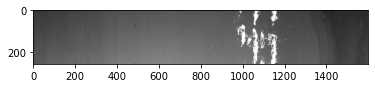

In [4]:
path = os.path.join(input_dir_Train, filelist_Train[12555])
image = cv2.imread(path)
plt.imshow(image)
print('image shape : {}'.format(image.shape))

In [5]:
df_path = os.path.join(input_dir, 'train.csv')
df = pd.read_csv(df_path)
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [6]:
print('defect num : {}'.format(df['ImageId'].nunique()))
print('no defect num : {}'.format(len(filelist_Train) - df['ImageId'].nunique()))

defect num : 6666
no defect num : 5902


In [7]:
num_classes = 4 + 1

In [8]:
defect_class = np.zeros((4))
for i in tqdm(range(len(df))):
    class_id = df.iloc[i]['ClassId']
    defect_class[class_id - 1] += 1

Text(0.5, 0, 'class')

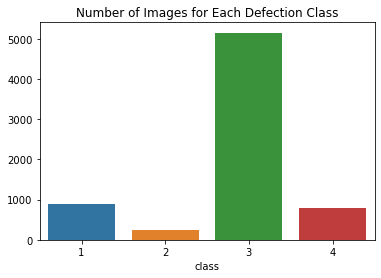

In [9]:
fig, ax = plt.subplots()
sns.barplot(x=np.arange(1, 5), y=defect_class, ax=ax)
ax.set_title("Number of Images for Each Defection Class")
ax.set_xlabel("class")

In [10]:
seed = 1234
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [11]:
def make_df(df):
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=seed)
    return train_df, val_df

In [12]:
train_df, val_df = make_df(df)

In [13]:
def make_mask(index, df):
    filename = df.iloc[index].name
    labels = df.iloc[index, :4]
    masks = np.zeros((256, 1600, 5), dtype=np.float32)
    for idx, label in enumerate(labels):
        if label is not np.nan:
            mask = np.zeros((256*1600), dtype=np.uint8)
            pixels = label.split(' ')
            pixels = [pixels[i:i+2] for i in range(0, len(pixels), 2)]
            for pixel in pixels:
                pos, le = pixel
                pos, le = int(pos), int(le)
                mask[pos-1:pos+le-1] = 1
            masks[:,:,idx+1] = mask.reshape(256, 1600, order = 'F')
        masks[:,:,0] = ~(np.sum(masks[:,:,1:], axis=2)>0)
    return filename, masks

file name : d5bdfa378.jpg


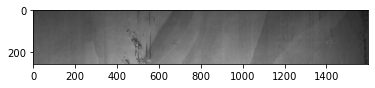

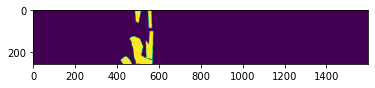

In [14]:
f, m = make_mask(100, train_df)
print('file name : {}'.format(f))
plt.imshow(cv2.imread(os.path.join(input_dir_Train, f)))
plt.show()
plt.imshow(m[:,:,3])
plt.show()

In [15]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
def get_augmentation(mean, std, phase):
    #这里用的albumentations库，据说比torch功能更多
    if phase == 'train':
        transform = [
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
            # albu.Resize(256, 256, interpolation=cv2.INTER_NEAREST, p=1),
            albu.Normalize(mean=mean, std=std, p=1),
            albu.pytorch.ToTensor(),
        ]
    else:
        transform = [
            # albu.Resize(256, 256, interpolation=cv2.INTER_NEAREST, p=1),
            albu.Normalize(mean=mean, std=std, p=1),
            albu.pytorch.ToTensor(),
        ]
    
    return albu.Compose(transform)

In [16]:
class SteelDataset(torch.utils.data.Dataset):
    def __init__(self, df, input_dir, phase):
        self.df = df
        self.input_dir = input_dir
        self.transforms = get_augmentation(mean, std, phase) 
        self.phase = phase
    def __getitem__(self, idx):
        filename, mask = make_mask(idx, self.df)
        # mask = np.argmax(mask, axis=-1)
        image = cv2.imread(os.path.join(self.input_dir, filename))
        augmented = self.transforms(image=image, mask=mask)
        image, mask = augmented['image'], augmented['mask']
        mask = mask[0].permute(2, 0, 1)
        # mask[0] += 0.5
        # mask = torch.argmax(mask)
        return image, mask
    def __len__(self):
        return len(self.df)
        

torch.Size([3, 256, 1600])


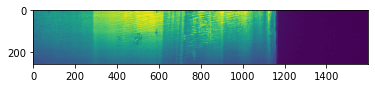

torch.Size([5, 256, 1600])


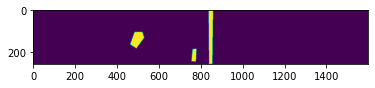

In [17]:
train_dataset = SteelDataset(train_df, input_dir_Train, phase = 'train')
val_dataset = SteelDataset(val_df, input_dir_Train, phase = 'val')

index = 0
image, mask = train_dataset.__getitem__(index) 
print(image.size())
plt.imshow(image.to(device).cpu().detach().numpy().copy()[0])
plt.show()
print(mask.size())
plt.imshow(mask.to(device).cpu().detach().numpy().copy()[3])
plt.show()

In [18]:
BATCH_SIZE = 1
EPOCHS = 30
SAVE_EPOCH = 5
VAL_EPOCH = 5
LR = 0.01
HALF_PERIOD = 25
loss_func = nn.CrossEntropyLoss(ignore_index=0)

pth_path = "E:/pth/"
if not os.path.exists(pth_path):
    os.makedirs(pth_path)

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [20]:
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print('inputs size : {}'.format(inputs.size()))
print('labels size : {}'.format(labels.size()))

inputs size : torch.Size([1, 3, 256, 1600])
labels size : torch.Size([1, 5, 256, 1600])


In [21]:
class FullModel(nn.Module):
    def __init__(self, input_size, num_classes, W=32, **kwargs):
        super(FullModel, self).__init__()
        self.model = get_HRNet_OCR_model(num_classes=num_classes, W=W, **kwargs)
        self.upsample = nn.Upsample(size=input_size, mode="bilinear")
        
    def forward(self, x):
        output = self.model(x)
        return [self.upsample(output[0]), self.upsample(output[1])]

In [22]:
model = FullModel(input_size=(256, 1600), num_classes=5, W=48).to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0001, nesterov=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=5)

In [23]:
pth_files = sorted(os.listdir(path=pth_path))
if len(pth_files) >= 1:
    state_dict = torch.load(os.path.join(pth_path, pth_files[-1]))
    epoch_ = state_dict["epoch"]
    model.load_state_dict(state_dict=state_dict["model"])
    optimizer.load_state_dict(state_dict=state_dict["optimizer"])
    scheduler.load_state_dict(state_dict=state_dict["scheduler"])
    train_loss = state_dict["train_loss"]
    train_acc = state_dict["train_acc"]
    val_loss = state_dict["val_loss"]
    val_acc = state_dict["val_acc"]
else:
    epoch_ = 1
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

In [24]:
class FullModel(nn.Module):
    def __init__(self, input_size, num_classes, W=32, **kwargs):
        self.model = get_HRNet_OCR_model(num_classes=num_classes, W=W, **kwargs)
        self.upsample = nn.Upsample(size=input_size, mode="nearest", align_corners=True)
        
    def forward(self, x):
        output = self.model(x)
        return [self.upsample(output[0]), self.upsample(output[1])]

In [25]:
class MIOUComputer(object):
    def __init__(self, num_classes, ignore=0):
        self.dummy = np.identity(num_classes)
        self.ignore = ignore
        self.classes = [x for x in np.arange(num_classes) if x != ignore]
    
    def calc(self, output, mask):
        output = self.dummy[output.argmax(axis=1).cpu().numpy()].transpose(0, 3, 1, 2)[:, self.classes]
        mask = mask[:, self.classes].cpu().numpy()
        PP = output > 0.5
        PN = output < 0.5
        GP = mask > 0.5
        GN = mask < 0.5
        TP = (PP & GP).sum(axis=(2,3))
        FP = (PP & GN).sum(axis=(2,3))
        FN = (PN & GP).sum(axis=(2,3))
        mIoU = np.nanmean(TP / (TP + FP + FN))
        return mIoU
mIoU = MIOUComputer(num_classes=num_classes, ignore=0)

In [26]:
with torch.autograd.set_detect_anomaly(True):
    for epoch in range(epoch_, EPOCHS+1):
        running_train_loss1 = 0
        running_train_loss2 = 0
        running_train_acc1 = 0
        running_train_acc2 = 0
        running_train_sum = 0
        model.train()
        with tqdm(train_dataloader, desc="Epoch {}: ".format(epoch)) as tq:
            for batch in tq:
                img = batch[0].to(device)
                mask = batch[1].to(device)
                mask_ = mask.argmax(axis=1)
                output_aux, output = model(img)
                #按照原文应该有两个loss，权重可能需要进一步调整
                loss1 = loss_func(output_aux, mask_)
                loss2 = loss_func(output, mask_)
                loss = loss1 + loss2
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                num_total = img.shape[0] * img.shape[2] * img.shape[3]
                running_train_loss1 += float(loss1) * num_total
                running_train_loss2 += float(loss2) * num_total
                running_train_acc1 += mIoU.calc(output_aux, mask) * num_total
                running_train_acc2 += mIoU.calc(output, mask) * num_total
                running_train_sum += float(num_total)
                tq.set_postfix(collections.OrderedDict({"Loss": running_train_loss2 / running_train_sum, "Accuracy": running_train_acc2 / running_train_sum, "Loss_Aux": running_train_loss1 / running_train_sum, "Accuracy_Aux": running_train_acc1 / running_train_sum}))

        scheduler.step(running_train_loss2 / running_train_sum)
        train_loss.append((running_train_loss1/running_train_sum, running_train_loss2/running_train_sum))
        train_acc.append((running_train_acc1/running_train_sum, running_train_acc2/running_train_sum))
        torch.cuda.empty_cache()

        if epoch % VAL_EPOCH == 0:
            running_val_loss1 = 0
            running_val_loss2 = 0
            running_val_acc1 = 0
            running_val_acc2 = 0
            running_val_sum = 0
            model.eval()
            with torch.no_grad():
                with tqdm(val_dataloader, desc="Val - Epoch {}: ".format(epoch)) as tq:
                    for batch in tq:
                        img = batch[0].to(device)
                        mask = batch[1].to(device).argmax(axis=1)
                        output_aux, output = model(img)
                        #按照原文应该有两个loss
                        loss1 = loss_func(output_aux, mask)
                        loss2 = loss_func(output, mask)
                        num_total = img.shape[0] * img.shape[2] * img.shape[3]
                        running_val_loss1 += float(loss1) * num_total
                        running_val_loss2 += float(loss2) * num_total
                        running_val_acc1 += mIoU.calc(output_aux, mask) * num_total
                        running_val_acc2 += mIoU.calc(output, mask) * num_total
                        running_val_sum += float(num_total)
                        tq.set_postfix(collections.OrderedDict({"Val Loss": running_val_loss2 / running_val_sum, "Val Accuracy": running_val_acc2 / running_val_sum, "Val Loss_Aux": running_val_loss1 / running_val_sum, "Val Accuracy_Aux": running_val_acc1 / running_val_sum}))

            val_loss.append((running_val_loss1/running_val_sum, running_val_loss2/running_val_sum))
            val_acc.append((running_val_acc1/running_val_sum, running_val_acc2/running_val_sum))
            torch.cuda.empty_cache()

        if epoch % SAVE_EPOCH == 0:
            torch.save({"epoch": epoch,
                        "model": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        "train_loss": train_loss,
                        "train_acc": train_acc,
                        "val_loss": val_loss,
                        "val_acc": val_acc},
                        os.path.join(pth_path, "model_{}.pth".format(datetime.datetime.now().strftime("%Y%m%d%H%M%S"))))
        

KeyboardInterrupt: 